### Test case LVV-T1836 - Verify calculation of resolved-to-unresolved flux ratio errors

Verify that the DM system has provided code to assess whether the maximum RMS of the ratio of the error in integrated flux measurement between bright, isolated, resolved sources less than 10 arcsec in diameter and bright, isolated unresolved point sources is less than **ResSource = 2**.

#### Discussion:

This test can be verified using data products produced during regular reprocessing campaigns executed by the Data Management pipelines team. In particular, we will use the regularly-reprocessed HSC RC2 data as reprocessed with weekly pipelines version w_2024_34, in Butler collection “HSC/runs/RC2/w_2024_34/DM-45857".

In [1]:
from astropy.table import Table, vstack
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic

from lsst.daf.butler import Butler

To measure this, we will work on the `objectTable_tract` tables, executing the following steps _for each patch_:

- Apply a signal-to-noise (SNR) cut to select only bright sources. (Default: SNR > 100)
- Select isolated objects based on the "detect_isIsolated" flag.
- Select galaxies and stars based on their "refSizeExtendedness" values.
- Select only galaxies with diameters less than 10 arcsec (based on their moments-based trace sizes).
- Bin the flux error values for (separately) selected bright, isolated stars and galaxies into magnitude bins.
- Calculate the ratio of the median flux errors in each bin for resolved sources (galaxies) vs. unresolved (stars).
- Report summary statistics aggregating the magnitude-binned ratios, and return these statistics (mean, median, stdev, etc. over all magnitude bins for the patch).

(Note: these calculations are all currently being performed only for i-band measurements.)

All of these steps are wrapped into a single function called `res_source_patch` in the following cell:

In [2]:
def res_source_patch(objtab, binsize=0.5, magmin=18.0, magmax=28.0, snrcut=100.0):
    """Calculate the ResSource metric for each patch in a tract-level objectTable.

    Parameters
    ----------
    objtab : pandas `Dataframe`
        The objectTable_tract to calculate metrics over.
    binsize : `float` (default: 0.5)
        Binsize for magnitude bins in which to calculate statistics.
    magmin : `float` (default: 18.0)
        Minimum magnitude to include in the statistics.
    magmax : `float` (default: 28.0)
        Maximum magnitude to include in the statistics.
    snrcut : `float` (default: 100.0)
        Minimum signal-to-noise to include in statistics.

    Returns
    -------
    results_tab : Astropy `Table`
        Table with per-patch statistics for the resolved-to-unresolved flux ratio.
    """
    # i-band SNR (9-pixel aperture fluxes):
    snr = objtab['i_ap09Flux']/objtab['i_ap09FluxErr']

    # Cut down to only objects meeting the SNR cut:
    objtab = objtab[snr < snrcut]

    results_tab = Table()
    
    for patch in np.unique(objtab['patch']):
        # Extract only the patch of interest:
        objtab_tmp = objtab[objtab['patch'] == patch]

        # Calculate i-band magnitudes:
        imag = (objtab_tmp['i_cModelFlux'].values*u.nJy).to(u.ABmag)

        # trace radius from HSM moments
        # 0.168 arcsec/pixel; the 2.0 factor is radius-->diameter
        itrace_diam = 0.168*2.0*np.sqrt((objtab_tmp['shape_xx'] + objtab_tmp['shape_yy'])/2)

        # Pick objects with diameters less than 10 arcsec:
        oksize = (itrace_diam < 10.0)

        # Select isolated objects:
        iso = (objtab_tmp['detect_isIsolated'] > 0.5)
        # Select extended objects:
        gx = (objtab_tmp['refSizeExtendedness'] > 0.6)

        # Extract the flux errors and magnitudes for isolated stars and galaxies:
        flux_err_isostars = objtab_tmp[iso & ~gx]['i_cModelFluxErr']
        imag_isostars = imag[iso & ~gx]

        flux_err_isogx = objtab_tmp[iso & gx & oksize]['i_cModelFluxErr']
        imag_isogx = imag[iso & gx & oksize]

        # Calculate statistics in magnitude bins for both flux errors:
        bins = np.arange(magmin, magmax, binsize)

        # Use binned_statistic to calculate mean within each bin
        isostars_binned_median = binned_statistic(imag_isostars, flux_err_isostars, bins=bins, statistic='median')
        isogx_binned_median = binned_statistic(imag_isogx, flux_err_isogx, bins=bins, statistic='median')

        isostars_binned_count = binned_statistic(imag_isostars, flux_err_isostars, bins=bins, statistic='count')
        isogx_binned_count = binned_statistic(imag_isogx, flux_err_isogx, bins=bins, statistic='count')

        rms = np.sqrt(np.nanmean((isogx_binned_median.statistic/isostars_binned_median.statistic)**2))
        std = np.nanstd(isogx_binned_median.statistic/isostars_binned_median.statistic)
        median = np.nanmedian(isogx_binned_median.statistic/isostars_binned_median.statistic)
        mean = np.nanmean(isogx_binned_median.statistic/isostars_binned_median.statistic)

        if len(results_tab) < 1:
            results_tab['patch'] = [patch]
            results_tab['mean'] = [mean]
            results_tab['median'] = [median]
            results_tab['rms'] = [rms]
            results_tab['std'] = [std]
            results_tab['nstar'] = np.sum(isostars_binned_count.statistic)
            results_tab['ngx'] = np.sum(isogx_binned_count.statistic)
        else:
            results_tab.add_row([patch, mean, median, rms, std,
                                 np.sum(isostars_binned_count.statistic),
                                 np.sum(isogx_binned_count.statistic)])
    
    return results_tab

The function in the following cell does the same calculation as above, but returns the values of the flux error ratios in each magnitude bin.

In [3]:
def res_source_magbins(objtab, binsize=0.5, magmin=18.0, magmax=28.0, snrcut=100.0):
    """Calculate the ResSource metric for an input objectTable and return the
    magnitude-binned ratios of flux errors.

    Parameters
    ----------
    objtab : pandas `Dataframe`
        The objectTable_tract to calculate metrics over.
    binsize : `float` (default: 0.5)
        Binsize for magnitude bins in which to calculate statistics.
    magmin : `float` (default: 18.0)
        Minimum magnitude to include in the statistics.
    magmax : `float` (default: 28.0)
        Maximum magnitude to include in the statistics.
    snrcut : `float` (default: 100.0)
        Minimum signal-to-noise to include in statistics.

    Returns
    -------
    bin_centers : `list`
        List of central magnitudes for bins.
    fluxerr_ratio : `list`
        List with resolved-to-unresolved flux ratio for each bin.
    """
    # i-band SNR (9-pixel aperture fluxes):
    snr = objtab['i_ap09Flux']/objtab['i_ap09FluxErr']

    # Cut down to only objects meeting the SNR cut:
    objtab = objtab[snr < snrcut]

    # Calculate i-band magnitudes:
    imag = (objtab['i_cModelFlux'].values*u.nJy).to(u.ABmag)

    # trace radius from HSM moments
    # 0.168 arcsec/pixel; the 2.0 factor is radius-->diameter
    itrace_diam = 0.168*2.0*np.sqrt((objtab['shape_xx'] + objtab['shape_yy'])/2)

    # Pick objects with diameters less than 10 arcsec:
    oksize = (itrace_diam < 10.0)

    # Select isolated objects:
    iso = (objtab['detect_isIsolated'] > 0.5)
    # Select extended objects:
    gx = (objtab['refSizeExtendedness'] > 0.6)

    # Extract the flux errors and magnitudes for isolated stars and galaxies:
    flux_err_isostars = objtab[iso & ~gx]['i_cModelFluxErr']
    imag_isostars = imag[iso & ~gx]

    flux_err_isogx = objtab[iso & gx & oksize]['i_cModelFluxErr']
    imag_isogx = imag[iso & gx & oksize]

    # Calculate statistics in magnitude bins for both flux errors:
    bins = np.arange(magmin, magmax, binsize)

    # Use binned_statistic to calculate mean within each bin
    isostars_binned_median = binned_statistic(imag_isostars, flux_err_isostars, bins=bins, statistic='median')
    isogx_binned_median = binned_statistic(imag_isogx, flux_err_isogx, bins=bins, statistic='median')

    isostars_binned_count = binned_statistic(imag_isostars, flux_err_isostars, bins=bins, statistic='count')
    isogx_binned_count = binned_statistic(imag_isogx, flux_err_isogx, bins=bins, statistic='count')

    bin_centers = isostars_binned_median.bin_edges[:-1]+binsize/2,
    fluxerr_ratio = isogx_binned_median.statistic/isostars_binned_median.statistic

    return bin_centers[0], fluxerr_ratio

In [4]:
# Initialize the butler repo pointing to the DM-45857 (w_2024_34) collection
repo = '/repo/main'
collection = 'HSC/runs/RC2/w_2024_34/DM-45857'

butler = Butler(repo, collections=collection)

In [5]:
did9615 = {'tract':9615, 'skymap':'hsc_rings_v1'}
did9697 = {'tract':9697, 'skymap':'hsc_rings_v1'}
did9813 = {'tract':9813, 'skymap':'hsc_rings_v1'}

In [6]:
objtable_columns = ['patch', 'detect_isIsolated', 'refSizeExtendedness',
                    'i_cModelFlux', 'i_cModelFluxErr',
                    'i_ap09Flux', 'i_ap09FluxErr',
                    'shape_xx', 'shape_yy']

Retrieve (a subset of columns from) the object table for each tract:

In [7]:
objtab9615 = butler.get('objectTable_tract', dataId=did9615, parameters={'columns':objtable_columns})
objtab9697 = butler.get('objectTable_tract', dataId=did9697, parameters={'columns':objtable_columns})
objtab9813 = butler.get('objectTable_tract', dataId=did9813, parameters={'columns':objtable_columns})

Call the `res_source_patch` function to calculate the flux error ratio statistics for all the patches from each tract:

In [8]:
stats9615 = res_source_patch(objtab9615)
stats9697 = res_source_patch(objtab9697)
stats9813 = res_source_patch(objtab9813)

/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astrop

In [9]:
# Display the first few lines of one of these tables:

stats9615[:3]

patch,mean,median,rms,std,nstar,ngx
int64,float64,float64,float64,float64,float64,float64
0,1.379818744206892,1.3687001525446552,1.391558352842168,0.18037428447570564,8973.0,7623.0
1,1.395631324196225,1.381067215812839,1.4005027305427702,0.11670949053117688,8248.0,7625.0
2,1.42108706431652,1.3952461949832835,1.432290593432857,0.17879569253340394,8562.0,7498.0


Print the mean and standard deviation over patches of the metrics for each tract to the screen:

In [10]:
tract9615_mean = np.nanmean(stats9615['median'])
tract9697_mean = np.nanmean(stats9697['median'])
tract9813_mean = np.nanmean(stats9813['median'])
tract9615_std = np.nanstd(stats9615['median'])
tract9697_std = np.nanstd(stats9697['median'])
tract9813_std = np.nanstd(stats9813['median'])

print('\nMean values, stdev for each RC2 tract')
print('-------------------------------------\n')
print(f'tract 9615: mean={tract9615_mean:.3f}, std={tract9615_std:.3f}')
print(f'tract 9697: mean={tract9697_mean:.3f}, std={tract9697_std:.3f}')
print(f'tract 9813: mean={tract9813_mean:.3f}, std={tract9813_std:.3f}\n')



Mean values, stdev for each RC2 tract
-------------------------------------

tract 9615: mean=1.386, std=0.020
tract 9697: mean=1.438, std=0.071
tract 9813: mean=1.261, std=0.086



The mean of all the patch median values for the resolved-to-unresolved flux ratio, for bright (SNR>100), isolated sources, corresponds to the `ResSource` quantity specified in the requirement. We see that this is well below the required value of 2.0 for each of the RC2 tracts.

### Plots

Plot the resolved/unresolved flux error ratio in magnitude bins for a full tract:

In [11]:
bincen, fluxerr_ratios = res_source_magbins(objtab9615, binsize=0.5)

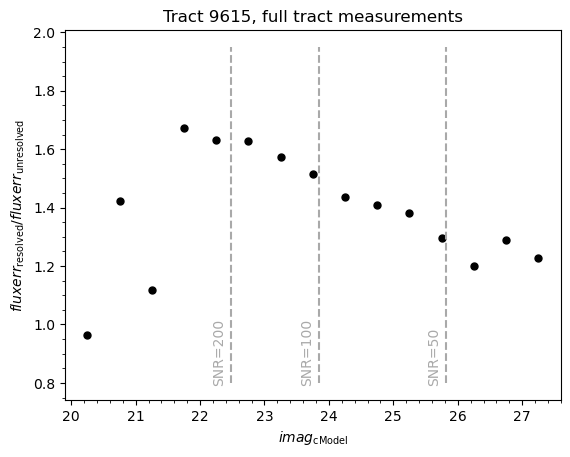

In [12]:
snr9615 = objtab9615['i_ap09Flux']/objtab9615['i_ap09FluxErr']
imag9615 = (objtab9615['i_cModelFlux'].values*u.nJy).to(u.ABmag)
oksnr50 = (snr9615 > 50)
maxmag50 = np.nanmax(imag9615[oksnr50].value)
oksnr100 = (snr9615 > 100)
maxmag100 = np.nanmax(imag9615[oksnr100].value)
oksnr200 = (snr9615 > 200)
maxmag200 = np.nanmax(imag9615[oksnr200].value)

plt.plot(bincen, fluxerr_ratios, 'k.', ms=10)
plt.vlines(maxmag50, 0.8, 1.95, linestyle='--', color='DarkGray')
plt.text(maxmag50-0.3, 0.8, 'SNR=50', rotation=90, color='DarkGray')
plt.vlines(maxmag100, 0.8, 1.95, linestyle='--', color='DarkGray')
plt.text(maxmag100-0.3, 0.8, 'SNR=100', rotation=90, color='DarkGray')
plt.vlines(maxmag200, 0.8, 1.95, linestyle='--', color='DarkGray')
plt.text(maxmag200-0.3, 0.8, 'SNR=200', rotation=90, color='DarkGray')
plt.minorticks_on()
plt.xlabel(r'$imag_{\rm cModel}$')
plt.ylabel(r'$fluxerr_{\rm resolved}/fluxerr_{\rm unresolved}$') #ratio of cModel flux errors
plt.title('Tract 9615, full tract measurements')
plt.show()

Plot the resolved/unresolved flux ratio in magnitude bins for a random set of 5 patches:

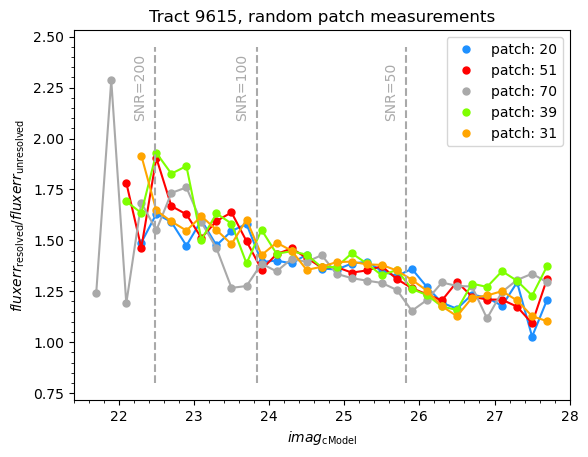

In [13]:
randpatches = np.random.randint(0, 80, 5)
colors = ['DodgerBlue', 'Red', 'DarkGray', 'Chartreuse', 'Orange']
fig, ax = plt.subplots()

for i in range(len(randpatches)):
    pch = randpatches[i]
    bincen_pch, fluxerr_ratios_pch = res_source_magbins(objtab9615[objtab9615['patch'] == pch], binsize=0.2)
    plt.plot(bincen_pch, fluxerr_ratios_pch, '.', ms=10, color=colors[i], label=f'patch: {pch}')
    plt.plot(bincen_pch, fluxerr_ratios_pch, color=colors[i], label='__none__')

plt.vlines(maxmag50, 0.8, 2.45, linestyle='--', color='DarkGray')
plt.text(maxmag50-0.3, 2.1, 'SNR=50', rotation=90, color='DarkGray')
plt.vlines(maxmag100, 0.8, 2.45, linestyle='--', color='DarkGray')
plt.text(maxmag100-0.3, 2.1, 'SNR=100', rotation=90, color='DarkGray')
plt.vlines(maxmag200, 0.8, 2.45, linestyle='--', color='DarkGray')
plt.text(maxmag200-0.3, 2.1, 'SNR=200', rotation=90, color='DarkGray')
plt.minorticks_on()
plt.legend()
plt.xlabel(r'$imag_{\rm cModel}$')
plt.ylabel(r'$fluxerr_{\rm resolved}/fluxerr_{\rm unresolved}$') #ratio of cModel flux errors
plt.title('Tract 9615, random patch measurements')
plt.show()

### Results

We have demonstrated that the photometric quality metric `ResSource` can be calculated based on quantities provided in the `objectTable` produced by the Rubin Science Pipelines. Thus the result of this test is a "**Pass**."